In [2]:
#This imports all past files and functions
import numpy as np
import astropy.units as u
import astropy.table as tbl
import matplotlib.pyplot as plt
from ReadFile import Read
from CenterOfMass import CenterOfMass
from astropy.constants import G


In [3]:
class MassProfile():
    ''' Class to calculate the Mass Profile. 
            
            PARAMETERS
            ----------
            galaxy: 'str'
                the galaxy
            snap: 'int'
                the SnapNumber
        '''
    def __init__(self, galaxy, snap):
        ''' Function to reconstruct the filenames 
        Inputs: galaxy: 'str'
                    the galaxy
                snap: 'int'
                    the SnapNumber
        '''
        #Inputs to reconstruct the filenames
        # add a string of the filenumber to the value “000” 
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename="%s_"%(galaxy) + ilbl + '.txt'
        
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)
        self.gname = galaxy
    
    
    
    def MassEnclosed(self, ptype, radii):
        ''' Function to compute mass enclosed within a given radius of COM position for galaxy/component 
        Inputs: galaxy: 'str'
                    the galaxy
                snap: 'int'
                    the SnapNumber
        '''
        radii = radii*u.kpc
        #Calculating center of mass here
        COM = CenterOfMass(self.filename, 2) #use disk particles always for CM
        p_COM = COM.COM_P(delta=0.1) #Calling function from COM notebook
        
        #create an array to store indexes of particles of desired Ptype                                
        index1 = np.where(self.data['type'] == ptype) #created variable only for ptype data
        ptype_data = self.data[index1] 
        
        #right length
        masses = np.zeros(len(radii))
        #looping through array, want index and positions, so:
        for i, radius in enumerate(radii):
            #Distances squared - finding all particles inside the 
            #radius by subtracting each particle's position from the COM and finding that distance
            index2 = np.where(np.sqrt((ptype_data['x']*u.kpc-p_COM[0])**2 + (ptype_data['y']*u.kpc-p_COM[1])**2 + (ptype_data['z']*u.kpc-p_COM[2])**2) < radius)
            data_rad = ptype_data[index2] 
            
            #sum of all masses of the particle type inside a certain r
            mass = np.sum(data_rad['m'])
            masses[i] = mass #filling out the masses array
            
        return masses*1e10*u.Msun
    
    
    
    def MassEnclosedTotal(self, radii):
        ''' Function to compute total mass enlosed in a given radii
        Inputs: radii (kpc)
        Outputs: total masses of particle types - masses_bulge+masses_disk+masses_halo
        '''
        
        #creating a 0 array for bulge and as long as not M33, it is filled out
        masses_bulge = np.zeros(len(radii))
        
        if self.gname != "M33": 
            masses_bulge = self.MassEnclosed(3,radii)
            
        masses_disk = self.MassEnclosed(2,radii)
        masses_halo = self.MassEnclosed(1,radii) #dark matter
        
        #adding up all the masses
        tot_mass = masses_bulge + masses_disk + masses_halo
        
        return tot_mass
    
    
    
    def HernquistMass(self, radius, a, Mhalo):
        ''' Function to compute the theoretical (Hernquist) mass profile
        Inputs: radius (kpc), scale factor=a, halo mass (Msun)
        Outputs: Mass profile (Msun)
        '''
        M = Mhalo*radius**2 / (a+radius)**2
        #rho = M*a / (2*np.pi*radius) / (radius + a)**3
    
        return M*u.Msun
        
        
        
    def CircularVelocity(self, ptype, radii):
        ''' Function to compute the circular speed using the mass enclosed at each radius
            **assume spherical symmetry
        Inputs: ptype=1,2,3, radii array
        Outputs: circular speeds (km/s)
        '''
        masses = self.MassEnclosed(ptype, radii)
        
        #gravitational constant
        grav_const = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        
        #getting radius into correct units
        radii = radii*u.kpc
            
        #This is element-by-element division - each mass gets divided by its corresponding radii
        v = np.sqrt(grav_const*masses/radii)
        
        #setting law of gravitation equal to circular force
        
        return v
    
    
    def CircularVelocityTotal(self, radii):
        ''' Function computes the sum of the squared velocities under a square root to get vtot
        Inputs: radii array
        Outputs: vtot_circ - total circular velocity
        '''
        vb = self.CircularVelocity(3, radii) #bulge comp circ velocity
        vd = self.CircularVelocity(2, radii) #disk comp circ velocity
        vh = self.CircularVelocity(1, radii) #halo comp circ velocity
        vtot_circ = np.sqrt(vb**2 + vd**2 + vh**2) #Computes tot circ velocity
        
        return vtot_circ
    
    
    def HernquistVCirc(self, radius, a, Mhalo):
        ''' Function computes the circular speed using the Hernquist mass profile
        Inputs: radius (kpc), scale factor=a, halo mass (Msun)
        Outputs: vtot_circ - total circular velocity (km/s)
        '''
        mass = self.HernquistMass(radius, a, Mhalo) #calling HernMass function
        
        #gravitational constant
        grav_const = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        
        #getting radius into correct units
        radius = radius*u.kpc
            
        #This is the Hernquist circular velocity - sqrt of GM/r
        v = np.round(np.sqrt(grav_const*mass/radius),2)
        
        return v


In [75]:
#Testing the code in above cell
MW = MassProfile("MW", 0) # initialize the MassProfile class for MW
r = np.arange(0.25, 30.5, 1.5); # create an array of radii as the input
MW.MassEnclosed(1, r) # get the enclosed halo masses at each element in 'r'

#makes sense - 0 mass as r=0
#numbers match example check closely!

<Quantity [0.00000000e+00, 1.26395200e+09, 4.54232750e+09, 9.20315050e+09,
           1.60363910e+10, 2.36991000e+10, 3.14803045e+10, 4.07624520e+10,
           5.26909990e+10, 6.34740895e+10, 7.57581230e+10, 8.82396490e+10,
           1.02380112e+11, 1.15651608e+11, 1.29871068e+11, 1.44169525e+11,
           1.58941964e+11, 1.73477412e+11, 1.85563953e+11, 1.98756452e+11,
           2.12659924e+11] solMass>

In [76]:
#Calling circular velocity function for disk particles within a given radius
MW.CircularVelocity(2,r)

<Quantity [117.02188081, 216.68808978, 199.17746082, 184.43721563,
           172.89420825, 163.13991242, 155.29719647, 149.2901649 ,
           144.13782478, 139.7707445 , 135.50941494, 131.68636388,
           127.96417193, 124.33825236, 120.82562305, 117.46289479,
           114.28065381, 111.2787813 , 108.39572172, 105.69868636,
           103.19571463] km / s>

In [32]:
#Plotting the Mass Profile for MW Galaxy
MW = MassProfile("MW", 0) # initialize the MassProfile class for MW
r = np.arange(0.1, 30.1, 1); # create an array of radii as the input
h_masses = MW.MassEnclosed(ptype=1, radii=r) #Using Mass Enclosed function for ptype 1
d_masses = MW.MassEnclosed(ptype=2, radii=r) #Using Mass Enclosed function for ptype 2
b_masses = MW.MassEnclosed(ptype=3, radii=r) #Using Mass Enclosed function for ptype 3
print(h_masses[-1]) #prints the total halo mass at 30kpc

HernquistMasses = MW.HernquistMass(radius=r, a=52, Mhalo=1.5e12)

201837335000.0 solMass


In [31]:
#Figuring out the correct scale factor
MW.HernquistMass(radius=30, a=52, Mhalo=1.5e12) #guessing a=52 to match solMass in above cell

<Quantity 2.00773349e+11 solMass>

Text(0.5, 1.0, 'Mass Profiles for Milky Way Components')

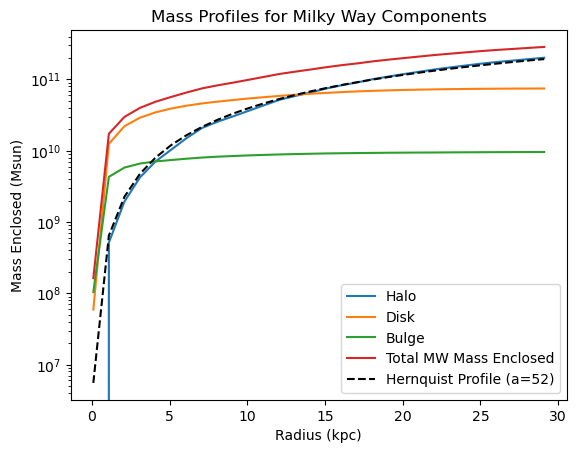

In [39]:
#Creating the figure and plotting mass enclosed vs radius for all MW components
fig, ax = plt.subplots()
ax.plot(r, h_masses, label="Halo")
ax.plot(r, d_masses, label="Disk")
ax.plot(r, b_masses, label="Bulge")
ax.plot(r, h_masses+d_masses+b_masses, label="Total MW Mass Enclosed")
ax.plot(r, HernquistMasses, label="Hernquist Profile (a=52)", linestyle="--", color="k")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Mass Enclosed (Msun)")
plt.semilogy() #log plot for y axis
plt.title("Mass Profiles for Milky Way Components")

#Hernquist Mass profile matches well with the Halo profile with a=52

In [55]:
#Plotting the Mass Profile for M31 Galaxy
M31 = MassProfile("M31", 0) # initialize the MassProfile class for M31
r = np.arange(0.1, 30.1, 1); # create an array of radii as the input
h_masses = M31.MassEnclosed(ptype=1, radii=r) #Using Mass Enclosed function for ptype 1
d_masses = M31.MassEnclosed(ptype=2, radii=r) #Using Mass Enclosed function for ptype 2
b_masses = M31.MassEnclosed(ptype=3, radii=r) #Using Mass Enclosed function for ptype 3
print(h_masses[-1]) #prints the total halo mass at 30kpc

HernquistMasses = M31.HernquistMass(radius=r, a=67, Mhalo=2.1e12)


196313936000.00003 solMass


In [56]:
#Figuring out the correct scale factor
M31.HernquistMass(radius=30, a=67, Mhalo=2.1e12) #guessing a=67 to match solMass in above cell

<Quantity 2.00871506e+11 solMass>

Text(0.5, 1.0, 'Mass Profiles for M31 Components')

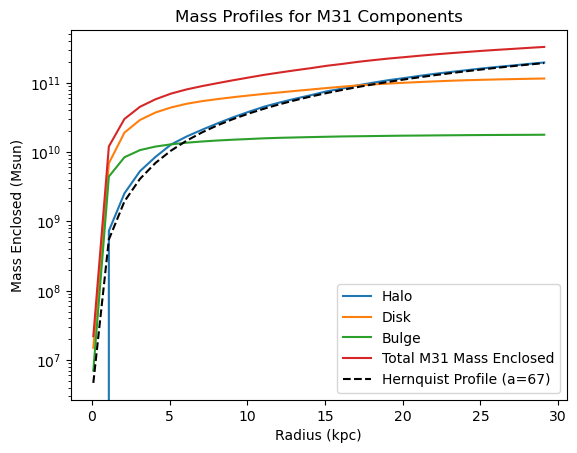

In [57]:
#Creating the figure and plotting mass enclosed vs radius for all M31 components
fig, ax = plt.subplots()
ax.plot(r, h_masses, label="Halo")
ax.plot(r, d_masses, label="Disk")
ax.plot(r, b_masses, label="Bulge")
ax.plot(r, h_masses+d_masses+b_masses, label="Total M31 Mass Enclosed")
ax.plot(r, HernquistMasses, label="Hernquist Profile (a=67)", linestyle="--", color="k")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Mass Enclosed (Msun)")
plt.semilogy() #log plot for y axis
plt.title("Mass Profiles for M31 Components")

#Hernquist Mass profile matches well with the Halo profile with a=67

In [104]:
#Plotting the Mass Profile for M33 Galaxy
M33 = MassProfile("M33", 0) # initialize the MassProfile class for M33
r = np.arange(0.1, 30.1, 1); # create an array of radii as the input
h_masses = M33.MassEnclosed(ptype=1, radii=r) #Using Mass Enclosed function for ptype 1
d_masses = M33.MassEnclosed(ptype=2, radii=r) #Using Mass Enclosed function for ptype 2
b_masses = M33.MassEnclosed(ptype=3, radii=r) #Using Mass Enclosed function for ptype 3
print(h_masses[-1]) #prints the total halo mass at 30kpc

print(f"M33 Enclosed Halo Mass @ 500kpc: {M33.MassEnclosed(1,[500])}")
HernquistMasses = M33.HernquistMass(radius=r, a=25, Mhalo=1.7e11)


54341705600.00001 solMass
M33 Enclosed Halo Mass @ 500kpc: [1.71236089e+11] solMass


In [105]:
#Figuring out the correct scale factor -> DM mass = 5e10 Msun
M33.HernquistMass(radius=30, a=25, Mhalo=1.7e11) #guessing a=25 to match solMass in above cell

<Quantity 5.05785124e+10 solMass>

Text(0.5, 1.0, 'Mass Profiles for M33 Components')

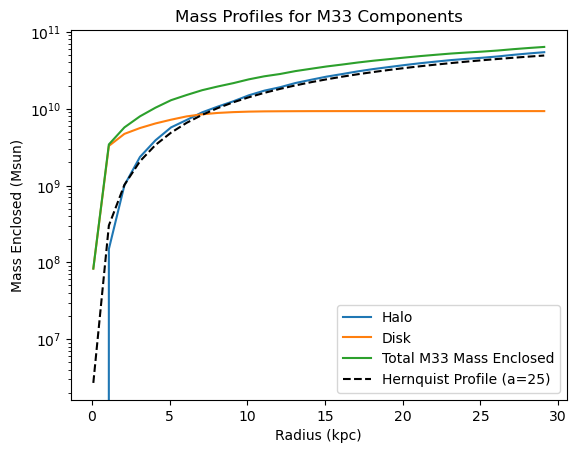

In [106]:
#Creating the figure and plotting mass enclosed vs radius for all M33 components
fig, ax = plt.subplots()
ax.plot(r, h_masses, label="Halo")
ax.plot(r, d_masses, label="Disk")
ax.plot(r, h_masses+d_masses, label="Total M33 Mass Enclosed")
ax.plot(r, HernquistMasses, label="Hernquist Profile (a=25)", linestyle="--", color="k")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Mass Enclosed (Msun)")
plt.semilogy() #log plot for y axis
plt.title("Mass Profiles for M33 Components")

#Hernquist Mass profile matches well with the Halo profile with a=25

In [111]:
#Calling CircularVelocity function for ptypes of MW
Halo_vel = MW.CircularVelocity(ptype=1, radii=r)
Disk_vel = MW.CircularVelocity(ptype=2, radii=r)
Bulge_vel = MW.CircularVelocity(ptype=3, radii=r)
tot_vel = MW.CircularVelocityTotal(radii=r)
HernquistCircularVel = MW.HernquistVCirc(radius=r, a=52, Mhalo=1.5e12)

Text(0.5, 1.0, 'Rotation Curve for MW Components')

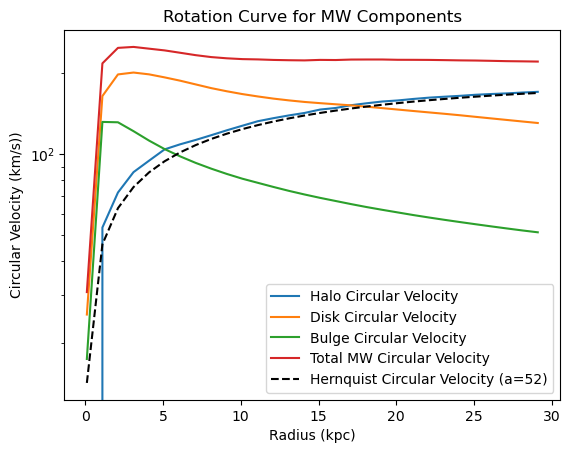

In [118]:
#Creating the figure and plotting rotation curves for MW galaxy
fig, ax = plt.subplots()
ax.plot(r, Halo_vel, label="Halo Circular Velocity")
ax.plot(r, Disk_vel, label="Disk Circular Velocity")
ax.plot(r, Bulge_vel,label="Bulge Circular Velocity")
ax.plot(r, tot_vel, label="Total MW Circular Velocity")
ax.plot(r, HernquistCircularVel, label="Hernquist Circular Velocity (a=52)", linestyle="--", color="k")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s))")
plt.semilogy() #log plot for y axis
plt.title("Rotation Curve for MW Components")

#Rotation curve for MW Halo matches Hernquist circular velocity curve at a=52

In [123]:
#Calling CircularVelocity function for ptypes of M31
Halo_vel = M31.CircularVelocity(ptype=1, radii=r)
Disk_vel = M31.CircularVelocity(ptype=2, radii=r)
Bulge_vel = M31.CircularVelocity(ptype=3, radii=r)
tot_vel = M31.CircularVelocityTotal(radii=r)
HernquistCircularVel = M31.HernquistVCirc(radius=r, a=67, Mhalo=2.1e12)

Text(0.5, 1.0, 'Rotation Curve for M31 Components')

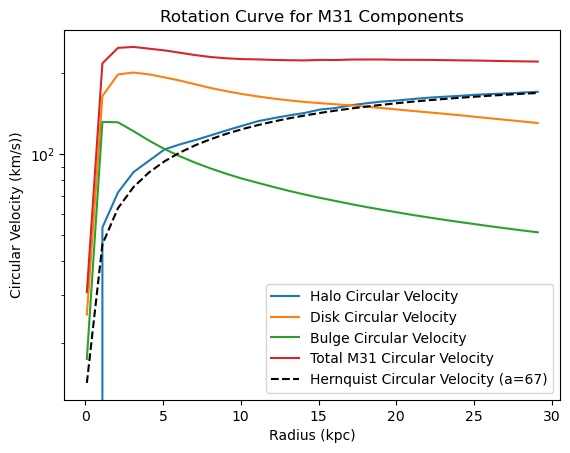

In [124]:
#Creating the figure and plotting rotation curves for M31 galaxy
fig, ax = plt.subplots()
ax.plot(r, Halo_vel, label="Halo Circular Velocity")
ax.plot(r, Disk_vel, label="Disk Circular Velocity")
ax.plot(r, Bulge_vel,label="Bulge Circular Velocity")
ax.plot(r, tot_vel, label="Total M31 Circular Velocity")
ax.plot(r, HernquistCircularVel, label="Hernquist Circular Velocity (a=67)", linestyle="--", color="k")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s))")
plt.semilogy() #log plot for y axis
plt.title("Rotation Curve for M31 Components")

#Rotation curve for M31 Halo matches Hernquist circular velocity curve at a=67

In [125]:
#Calling CircularVelocity function for ptypes of M33
Halo_vel = M33.CircularVelocity(ptype=1, radii=r)
Disk_vel = M33.CircularVelocity(ptype=2, radii=r)
Bulge_vel = M33.CircularVelocity(ptype=3, radii=r)
tot_vel = M33.CircularVelocityTotal(radii=r)
HernquistCircularVel = M33.HernquistVCirc(radius=r, a=25, Mhalo=1.7e11)

Text(0.5, 1.0, 'Rotation Curve for M33 Components')

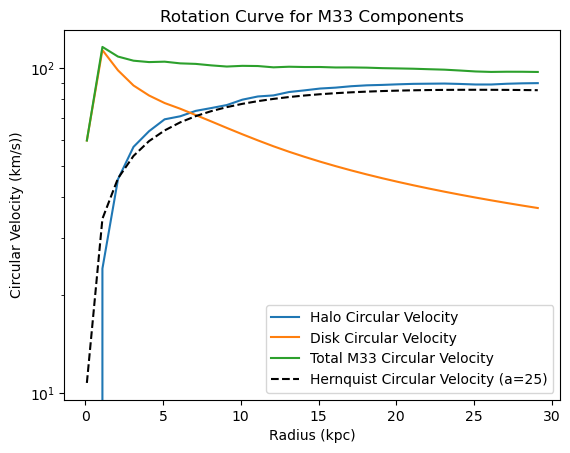

In [127]:
#Creating the figure and plotting rotation curves for M33 galaxy
fig, ax = plt.subplots()
ax.plot(r, Halo_vel, label="Halo Circular Velocity")
ax.plot(r, Disk_vel, label="Disk Circular Velocity")
ax.plot(r, tot_vel, label="Total M33 Circular Velocity")
ax.plot(r, HernquistCircularVel, label="Hernquist Circular Velocity (a=25)", linestyle="--", color="k")
plt.legend()
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s))")
plt.semilogy() #log plot for y axis
plt.title("Rotation Curve for M33 Components")

#Rotation curve for M33 Halo matches Hernquist circular velocity curve at a=25